In [1]:
!mkdir -p Data
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat -O Data/burgers_shock.mat
!pip install pyDOE

--2024-04-14 20:06:29--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2024-04-14 20:06:29--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘Data/burgers_shock.mat’

Data/burgers_shock. 100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2024-04-14 20:06:30 (12.6 MB/s) - ‘Data/burgers_shock.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from scipy.spatial import Delaunay
from pyDOE import lhs
import time
from torch.autograd import Variable
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:

class PhysicsInformedNN(nn.Module):
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        super(PhysicsInformedNN, self).__init__()
        self.lb = torch.Tensor(lb).float()
        self.ub = torch.Tensor(ub).float()

        self.x_u = torch.Tensor(X_u[:, 0:1]).float()
        self.t_u = torch.Tensor(X_u[:, 1:2]).float()
        self.x_f = torch.Tensor(X_f[:, 0:1]).float()
        self.t_f = torch.Tensor(X_f[:, 1:2]).float()
        self.u = torch.Tensor(u).float()

        self.layers = layers
        self.nu = nu

        self.model = self.neural_net(layers)
        self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=1.0,
                                           max_iter=50000, max_eval=50000,
                                           tolerance_grad=1.0*np.finfo(float).eps)

    # n-1 (len(layers)) Tanh layer
    def neural_net(self, layers):
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        return nn.Sequential(*modules)

    def forward(self, x, t):
        u = self.model(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        u = self.forward(x, t)

        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        f = u_t + u*u_x - self.nu*u_xx

        return f

    #MSE = MSE_u + MSE_f
    def loss_fn(self):
        u_pred = self.forward(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)

        loss = torch.mean((self.u - u_pred)**2) + torch.mean(f_pred**2)
        return loss

    def train(self):
        def closure():
            self.optimizer.zero_grad()
            loss = self.loss_fn()
            loss.backward()
            print('Loss:', loss.item())
            return loss

        self.optimizer.step(closure)

    def predict(self, X_star):
        self.model.eval()
        X_star = torch.Tensor(X_star).float()
        u_star = self.forward(X_star[:, 0:1], X_star[:, 1:2])
        f_star = self.net_f(X_star[:, 0:1], X_star[:, 1:2])

        return u_star.detach().numpy(), f_star.detach().numpy()

In [4]:
# Set device for PyTorch, but not really necessary since it's pretty lightweight
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nu = 0.01/np.pi
noise = 0.0

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]


X_u_train = torch.tensor(X_u_train, requires_grad=True).float().to(device)
u_train = torch.tensor(u_train).float().to(device)
X_f_train = torch.tensor(X_f_train, requires_grad=True).float().to(device)
lb = torch.tensor(lb).float().to(device)
ub = torch.tensor(ub).float().to(device)

model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu).to(device)

start_time = time.time()
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % elapsed)

# Predict
X_star = torch.tensor(X_star, requires_grad=True).float().to(device)
u_star = torch.tensor(u_star).float().to(device)

u_pred, f_pred = model.predict(X_star)


error_u = np.linalg.norm(u_star.cpu().numpy()-u_pred,2)/np.linalg.norm(u_star.cpu().numpy(),2)
print('Error u: %e' % (error_u))

U_pred = griddata(X_star.detach().numpy(), u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)


Loss: 0.2635396718978882
Loss: 0.2579021155834198
Loss: 0.2572705149650574
Loss: 0.25720661878585815
Loss: 0.25366196036338806
Loss: 0.24442413449287415
Loss: 0.23318453133106232
Loss: 0.23110038042068481
Loss: 0.22487863898277283
Loss: 0.21601583063602448
Loss: 0.2242337167263031
Loss: 0.20690864324569702
Loss: 0.20516470074653625
Loss: 0.20422671735286713
Loss: 0.20311225950717926
Loss: 387.6140441894531
Loss: 0.19784602522850037
Loss: 0.1922696828842163
Loss: 0.5922223329544067
Loss: 0.19231554865837097
Loss: 0.4112496078014374
Loss: 0.2951982915401459
Loss: 0.1888638287782669
Loss: 0.23060593008995056
Loss: 18661.181640625
Loss: 0.18648989498615265
Loss: 0.17798440158367157
Loss: 0.2534373104572296
Loss: 0.17497514188289642
Loss: 0.19577066600322723
Loss: 0.16908223927021027
Loss: 0.16765883564949036
Loss: 0.16586695611476898
Loss: 0.16447286307811737
Loss: 0.15662702918052673
Loss: 0.153204545378685
Loss: 0.15261511504650116
Loss: 0.15236425399780273
Loss: 0.15212027728557587
Loss

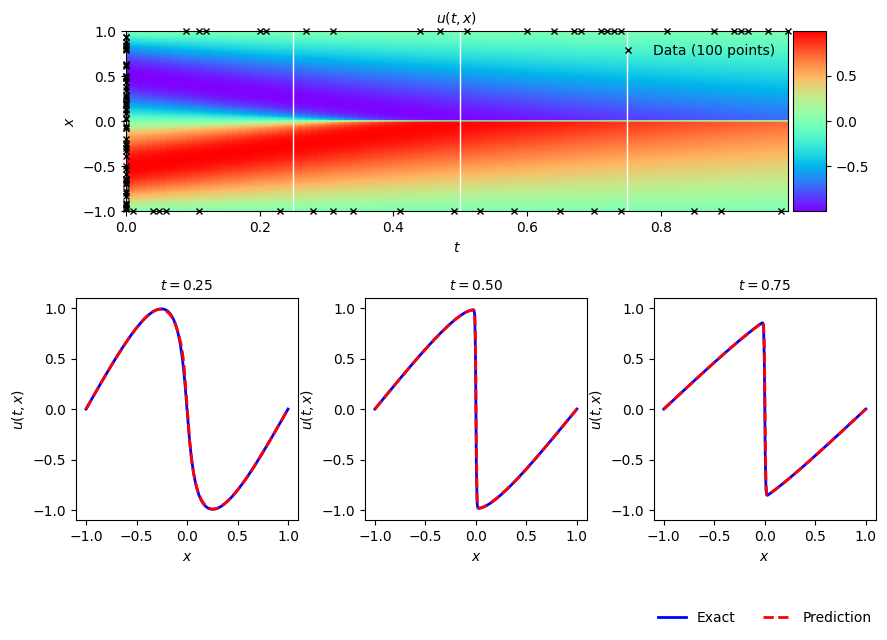

In [5]:
fig = plt.figure(figsize=(10, 6))

gs0 = gridspec.GridSpec(1, 2, top=0.93, bottom=0.63, left=0.15, right=0.85, wspace=0.05)
ax0 = fig.add_subplot(gs0[:, :])

h = ax0.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
               extent=[t.min(), t.max(), x.min(), x.max()],
               origin='lower', aspect='auto')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax0.plot(X_u_train.detach().numpy()[:, 1], X_u_train.detach().numpy()[:, 0], 'kx', label='Data (%d points)' % (u_train.shape[0]), markersize=4, clip_on=False)

lines_at = [0.25, 0.5, 0.75]
for line_at in lines_at:
    ax0.axvline(x=line_at, color='w', linestyle='-', linewidth=1)

ax0.set_xlabel('$t$')
ax0.set_ylabel('$x$')
ax0.legend(frameon=False, loc='best')
ax0.set_title('$u(t,x)$', fontsize=10)

gs1 = gridspec.GridSpec(1, 3, top=0.53, bottom=0.07, left=0.1, right=0.9, wspace=0.3)
time_points = [25, 50, 75]
titles = ['$t = 0.25$', '$t = 0.50$', '$t = 0.75$']

for i, (tp, title) in enumerate(zip(time_points, titles)):
    ax = fig.add_subplot(gs1[0, i])
    ax.plot(x, Exact[tp, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[tp, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title(title, fontsize=10)
    if i == 2:  # Add a legend only for the last plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=2, frameon=False)